##### Final Exam - DTSC6007001 Deep Learning

Nama: Vira Fitriyani <br>
NIM: 2602068706 <br>


#### Library

In [139]:
import os
import gzip
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Reshape, UpSampling2D, BatchNormalization, Dropout
from keras.optimizers import Adam
from skimage.metrics import structural_similarity as ssim
from scikeras.wrappers import KerasClassifier

#### 2a. Preprocessing Data

In [140]:
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [141]:
x_train, y_train = load_mnist('Dataset 2', kind='train')
x_test, y_test = load_mnist('Dataset 2', kind='t10k')

In [142]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

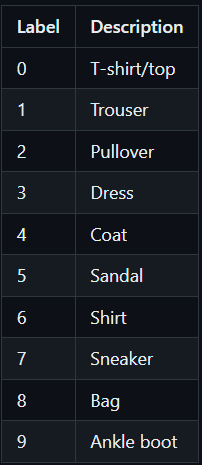

In [143]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


In [144]:
# Filter class Pullover[2] dan Dress[3]
filter_labels = [2, 3]
train_filter = np.isin(y_train, filter_labels)
test_filter = np.isin(y_test, filter_labels)

In [145]:
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]

In [146]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(12000, 784)
(12000,)
(2000, 784)
(2000,)


In [147]:
# Scaling Data [0,1]
x_train = x_train.astype('float32') / 255   #maksimum pixel -> 255
x_test = x_test.astype('float32') / 255

In [148]:
# Reshape mnist images to original 2D format (28, 28)
x_train = x_train.reshape(-1, 28, 28)
x_test = x_test.reshape(-1, 28,28)

In [149]:
# Combine train and test data
x_data = np.vstack((x_train, x_test))
y_data = np.hstack((y_train, y_test))

In [150]:
# Split data -> 80% train, 10% val, 10% test
x_train, x_temp, y_train, y_temp = train_test_split(x_data, y_data, test_size=0.2, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

In [151]:
print("Training set:", x_train.shape, y_train.shape)
print("Validation set:", x_val.shape, y_val.shape)
print("Test set:", x_test.shape, y_test.shape)

Training set: (11200, 28, 28) (11200,)
Validation set: (1400, 28, 28) (1400,)
Test set: (1400, 28, 28) (1400,)


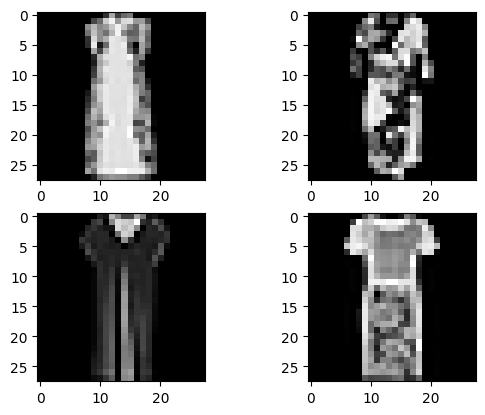

In [152]:
# Example of data mnist images
plt.subplot(221)
plt.imshow(x_train[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(x_train[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(x_train[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(x_train[3], cmap=plt.get_cmap('gray'))
plt.show()

#### 2b. Arsitektur Baseline

Dimension Reduction: 784 (28x28) -> dimensi 128 <br>
Menggunakan arsitektur Autoencoder yang bertujuan untuk memampatkan data input menjadi representasi laten yang lebih kecil (encoding) dan kemudian merekonstruksi data asli dari representasi laten tersebut (decoding).

In [153]:
input_dim = Input(shape=(28, 28, 1)) #1 -> grayscale
latent_dim = 128

In [63]:
# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_dim)    # konvolusi layer dengan 32 filter dan ukuran kernel 3x3
x = MaxPooling2D((2, 2), padding='same')(x)
x = Flatten()(x)
encoded = Dense(latent_dim, activation='relu')(x)

# Decoder
x = Dense(14 * 14 * 32, activation='relu')(encoded)   #mengubah latent_dim ke dimensi yg sesuai
x = Reshape((14, 14, 32))(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

* Encoder: menerima input gambar, menerapkan konvolusi pooling, dan mengubahnya menjadi representasi laten vektor 1 dimensi melalui dense layer (lapisan fully connected).
* Decoder: mengubah representasi laten kembali ke dimensi yang lebih besar melalui dense layer, reshaping, upsampling, dan konvolusi untuk menghasilkan gambar yang mirip dengan input asli.

In [64]:
autoencoder = Model(input_dim, decoded)
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6272)           │       809,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,621,889 (6.19 MB)

 Trainable params: 1,621,889 (6.19 MB)

 Non-trainable params: 0 (0.00 B)

In [65]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [66]:
history = autoencoder.fit(x_train, x_train, epochs=10, validation_data=(x_val, x_val))

Epoch 1/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.3834 - val_loss: 0.3034
Epoch 2/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.2982 - val_loss: 0.2927
Epoch 3/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.2878 - val_loss: 0.2888
Epoch 4/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.2857 - val_loss: 0.2859
Epoch 5/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.2831 - val_loss: 0.2843
Epoch 6/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.2819 - val_loss: 0.2838
Epoch 7/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.2823 - val_loss: 0.2827
Epoch 8/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.2796 - val_loss: 0.2817
Epoch 9/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.2793 - val_loss: 0.2814
Epoch 10/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.2789 - val_loss: 0.2809


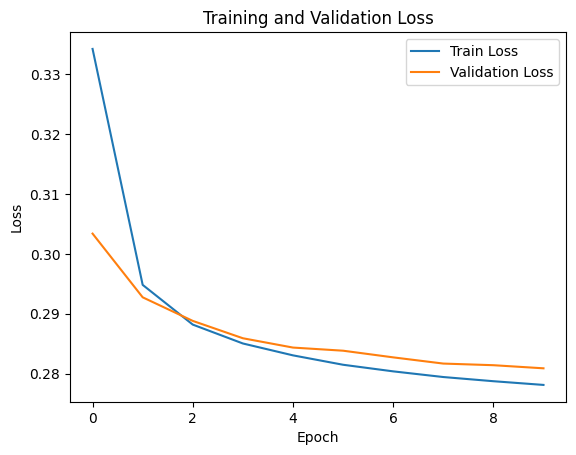

In [67]:
# Plot training and validation Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Interpretasi**:<br>
* Train Loss: pada epoch pertama train loss cukup tinggi sekitar 0.33, namun setelah epoch kedua train loss terus menurun secara bertahap hingga akhir pelatihan sekitar 0.28. Hal ini menunjukkan bahwa awalnya model autoencoder tidak dapat merekonstruksi data pelatihan dnegan baik, namun seiring berjalannya pelatihan model terus memperbaiki kemampuannya dalam merekonstruksi data.
* Validation Loss: validation loss juga cukup tinggi pada epoch pertama namun sedikit lebih rendah dari train loss yaitu sekitar 0.30. Dan mengalami penurunan seiring berjalannya pelatihan, hal ini menunjukkan bahwa model memiliki generalisasi yang baik.
* Penurunan yang konsisten dan stabil selama pelatihan sebenarnya indikasi bahwa model tidak mengalami overfitting.

In [68]:
# Evaluation SSIM
decoded_img = autoencoder.predict(x_test)
ssim_scores = []

for i in range(len(x_test)):
    ssim_score = ssim(x_test[i].reshape(28,28), decoded_img[i].reshape(28,28), data_range=decoded_img[i].max() - decoded_img[i].min())
    ssim_scores.append(ssim_score)

mean_ssim = np.mean(ssim_scores)
print("Mean SSIM score on the test set:", mean_ssim)

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Mean SSIM score on the test set: 0.841372491366539


**Interpretasi:** Dengan nilai 0.84, ini menunjukkan bahwa gambar yang dihasilkan oleh model memiliki kesamaan struktural yang tinggi dengan gambar aslinya.

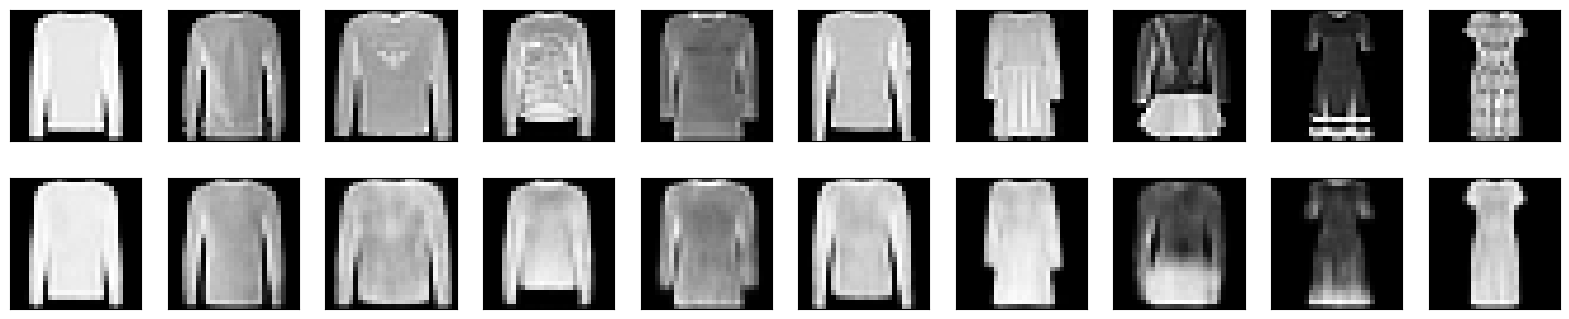

In [69]:
n = 10  
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original data
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_img[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

#### 2c. Modifikasi Arsitektur

Modifikasi Arsitektur:
1. Menambahkan layer batch normalization
2. Menambahkan layer Dropout
3. Menambahkan konvolusi layer
4. Mengubah Hyperparameter:
    * Meningkatkan jumlah epochs
    * Menggunakan batch_size

In [110]:
# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_dim)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Dropout(0.3)(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Dropout(0.3)(x)
x = Flatten()(x)
encoded = Dense(latent_dim, activation='relu')(x)

# Decoder
x = Dense(7 * 7 * 64, activation='relu')(encoded)
x = Reshape((7, 7, 64))(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

In [111]:
autoencoder_2 = Model(input_dim, decoded)
autoencoder_2.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 3136)           │       404,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_8 (Reshape)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_15 (UpSampling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_16 (UpSampling2D) │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 28, 28, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 881,345 (3.36 MB)

 Trainable params: 880,961 (3.36 MB)

 Non-trainable params: 384 (1.50 KB)

In [112]:
autoencoder_2.compile(optimizer='adam', loss='binary_crossentropy')

In [120]:
history_2 = autoencoder_2.fit(x_train, x_train, epochs=20, batch_size=32, validation_data=(x_val, x_val))

Epoch 1/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - loss: 0.2815 - val_loss: 0.2820
Epoch 2/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - loss: 0.2803 - val_loss: 0.2823
Epoch 3/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - loss: 0.2804 - val_loss: 0.2813
Epoch 4/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 23s 66ms/step - loss: 0.2823 - val_loss: 0.2827
Epoch 5/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 23s 66ms/step - loss: 0.2803 - val_loss: 0.2812
Epoch 6/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - loss: 0.2813 - val_loss: 0.2809
Epoch 7/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - loss: 0.2807 - val_loss: 0.2803
Epoch 8/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - loss: 0.2792 - val_loss: 0.2803
Epoch 9/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 27s 76ms/step - loss: 0.2795 - val_loss: 0.2803
Epoch 10/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - loss: 0.2787 - val_loss: 0.2799
Epoch 11/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - loss: 0.2791 - val_loss: 0.2804
Epoch 12/20
350/350 ━━━━━━━━━━

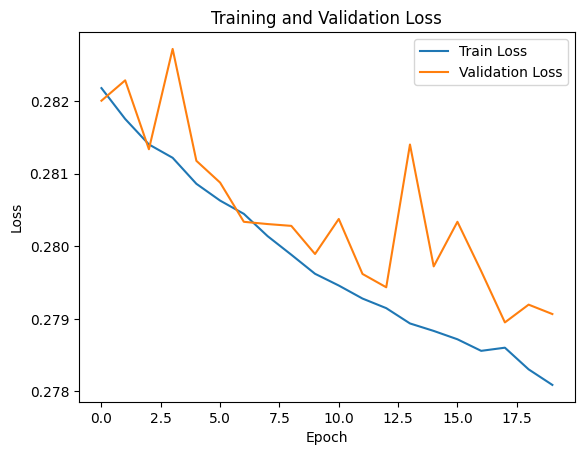

In [123]:
# Plot training and validation Loss
plt.plot(history_2.history['loss'], label='Train Loss')
plt.plot(history_2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Interpretasi**:<br>
* Train Loss: nilai loss pada training cenderung mengalami penurunan yang konsisten seiring dengan bertambahnya epoch pelatihan. Hal ini menunjukkan bahwa model semakin baik dalam merekonstruksi data input pada data training seiring waktu.
* Validation Loss: nilai loss pada validation juga cenderung menurun namun terdapat fluktuasi yang cukup signifikan dibandingkan dengan training loss. Namun pola masih menunjukkan tren penurunan yang berarti model juga semakin baik dalam merekonstruksi data pada data validasi.
* Perbedaan antara training dan validation loss tidak terlalu besar yang menunjukkan bahwa model memiliki generalisasi yang cukup baik dan tidak mengindikasikan overfitting. 

In [126]:
# Evaluation SSIM
decoded_img_2 = autoencoder_2.predict(x_test)
ssim_scores = []

for i in range(len(x_test)):
    ssim_score = ssim(x_test[i].reshape(28,28), decoded_img_2[i].reshape(28,28), data_range=decoded_img_2[i].max() - decoded_img_2[i].min())
    ssim_scores.append(ssim_score)

mean_ssim = np.mean(ssim_scores)
print("Mean SSIM score on the test set:", mean_ssim)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Mean SSIM score on the test set: 0.8596678604447225


**Intrepretasi:** Nilai SSIM yang didapatkan model modifikasi yaitu 0.86, meningkat dibandingkan SSIM model baseline. Perbandingan ini menunjukkan bahwa arsitektur model modifikasi menghasilkan gambar-gambar yang memiliki kesamaan struktural yang sedikit lebih tinggi dengan gambar asli dibandingkan dengan arsitektur baseline. Maka dari itu, arsitektur modifikasi dapat dianggap sedikit lebih baik dalam mempertahankan detail dan struktur gambar asli.

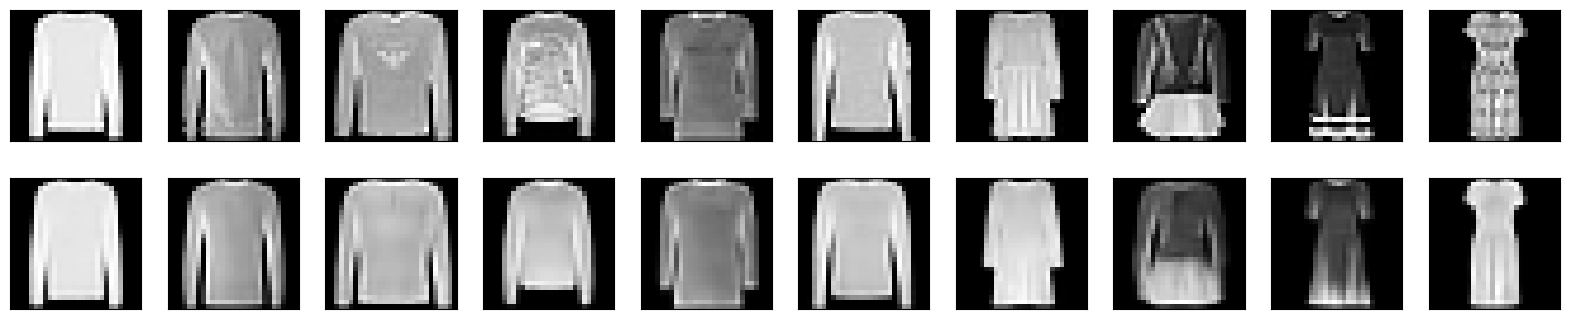

In [127]:
n = 10  
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original data
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_img_2[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

#### Tuning Hyperparameter

In [154]:
def build_autoencoder(hp):
    hiddenLayerOne = hp.Choice('hiddenLayerOne', [32, 64, 128])
    hiddenLayerTwo= hp.Choice('hiddenLayerTwo', [16, 32, 64])
    dropout = hp.Choice('dropout', [0.2, 0.3, 0.5])

    # Encoder
    x = Conv2D(hiddenLayerOne, (3, 3), activation='relu', padding='same')(input_dim)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(dropout)(x)
    x = Conv2D(hiddenLayerTwo, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(dropout)(x)
    x = Flatten()(x)
    encoded = Dense(hiddenLayerTwo, activation='relu')(x)

    # Decoder
    x = Dense(7 * 7 * 64, activation='relu')(encoded)
    x = Reshape((7, 7, 64))(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(hiddenLayerOne, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(hiddenLayerTwo, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder_3 = Model(input_dim, decoded)
    autoencoder_3.compile(optimizer='adam', loss='binary_crossentropy')

    return autoencoder_3

In [155]:
tuner = keras_tuner.RandomSearch(
    build_autoencoder,
    objective='val_loss',
    max_trials=5
)

Reloading Tuner from .\untitled_project\tuner0.json


In [135]:
# mengubah shape data agar sesuai dengan input dan output autoencoder
# 4D (samples, height, width, channels)
x_train = x_train.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# self-reconstruction (menggunakan data yang sama untuk input output)
y_train = x_train
y_val = x_val
y_test = x_test

print("Training set:", x_train.shape, y_train.shape)
print("Validation set:", x_val.shape, y_val.shape)
print("Test set:", x_test.shape, y_test.shape)

Training set: (11200, 28, 28, 1) (11200, 28, 28, 1)
Validation set: (1400, 28, 28, 1) (1400, 28, 28, 1)
Test set: (1400, 28, 28, 1) (1400, 28, 28, 1)


In [156]:
tuner.search(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

In [157]:
best_model = tuner.get_best_models()[0]
best_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3136)           │       103,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 229,249 (895.50 KB)

 Trainable params: 228,865 (894.00 KB)

 Non-trainable params: 384 (1.50 KB)

In [158]:
best_model.compile(optimizer='adam', loss='binary_crossentropy')

In [159]:
history_bestmodel = best_model.fit(x_train, x_train, epochs=10, batch_size=32, validation_data=(x_val, x_val))

Epoch 1/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step - loss: 0.2908 - val_loss: 0.2872
Epoch 2/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - loss: 0.2877 - val_loss: 0.2876
Epoch 3/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - loss: 0.2874 - val_loss: 0.2863
Epoch 4/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - loss: 0.2866 - val_loss: 0.2869
Epoch 5/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - loss: 0.2879 - val_loss: 0.2861
Epoch 6/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - loss: 0.2865 - val_loss: 0.2856
Epoch 7/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - loss: 0.2859 - val_loss: 0.2852
Epoch 8/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - loss: 0.2850 - val_loss: 0.2853
Epoch 9/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 25s 70ms/step - loss: 0.2854 - val_loss: 0.2849
Epoch 10/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - loss: 0.2864 - val_loss: 0.2846


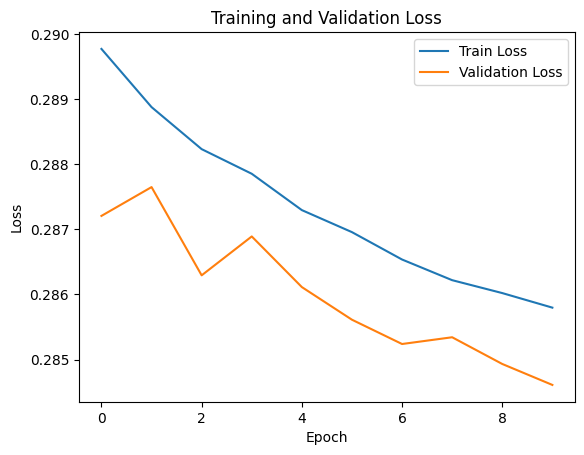

In [160]:
# Plot training and validation Loss
plt.plot(history_bestmodel.history['loss'], label='Train Loss')
plt.plot(history_bestmodel.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [161]:
# Evaluation SSIM
decoded_img_3 = best_model.predict(x_test)
ssim_scores = []

for i in range(len(x_test)):
    ssim_score = ssim(x_test[i].reshape(28,28), decoded_img_3[i].reshape(28,28), data_range=decoded_img_3[i].max() - decoded_img_3[i].min())
    ssim_scores.append(ssim_score)

mean_ssim = np.mean(ssim_scores)
print("Mean SSIM score on the test set:", mean_ssim)

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Mean SSIM score on the test set: 0.8084494383245685


**Interpretasi:**<br>
Model yang dihasilkan dari tunning hyperparameter menggunakan keras tuner masih belum memberikan best hyperparameter yang lebih baik dibandingkan baseline arsitektur maupun modifikasi arsitektur. Karena jika dilihat dari grafik, model dari tuning hyperparameter mengalami underfitting pada data pelatihan, dan menghasilkan nilai SSIM yang lebih rendah juga.